In [2]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
#from src.inference.models import LineDetector

from src.segmentation.gcn_model import GCN
from src.data.dataset_line_rider import DatasetLineRider
from src.data.dataset_inference import DatasetInference
#from src.inference.models import LineDetector
from src.utils.distances import get_median_diff, d2, get_smallest_distance
from torchvision import models
from src.utils.utils import load_class_dict
from src.utils.normalize_baselines import compute_start_and_angle

import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [37]:
def d2_np(u, v):
    return np.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)

def is_in_box(point, left, top, width, height):
    x = point[0]
    y = point[1]

    if left < x < left + width:
        if top < y < top + height:
            return True

    return False


def contains_start_point(points, bl_stats):
    comp_contains_sp = []
    for n, bl_s in enumerate(bl_stats):

        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3]

        if width > height:
            left -= 5
            width += 10
        else:
            top -= 5
            height += 10

        contains_sp_switch = False
        for p in points:
            if is_in_box(p, left, top, width, height):
                comp_contains_sp.append(True)
                contains_sp_switch = True
                break

        if not contains_sp_switch:
            comp_contains_sp.append(False)

    return comp_contains_sp

def get_cc_array(stats, area_thresh = 100):
    cc_array = np.zeros((len(stats), 4, 2))

    for n, cc in enumerate(stats):
        if cc[2]*cc[3] < area_thresh:
            top_left = -10000
            top_right = -10000
            bottom_left = -10000
            bottom_right = -10000
        else:
            top_left = np.array([cc[0], cc[1]])
            top_right = np.array([cc[0]+cc[2], cc[1]])
            bottom_left = np.array([cc[0], cc[1]+cc[3]])
            bottom_right = np.array([cc[0]+cc[2], cc[1]+cc[3]])

        cc_array[n, 0, :] = top_left
        cc_array[n, 1, :] = top_right
        cc_array[n, 2, :] = bottom_left
        cc_array[n, 3, :] = bottom_right
    
    return cc_array

def get_angles(cc_array, start_points):
    dist_array = -np.ones(cc_array.shape[0:2]) # The minus is for debug
    angles = np.zeros(len(start_points))
    
    for sp_idx, p in enumerate(start_points):
        for n in range(cc_array.shape[0]):
            for k in range(0,4):
                dist_array[n, k] = d2_np(p, cc_array[n, k, :])
                
        cc_idx, p_idx = np.unravel_index(np.argmin(dist_array, axis=None), dist_array.shape)
        
        if np.min(dist_array) < 0:
            print('something went wrong!')
            return 0
        
        bb_w = (cc_array[cc_idx, 1, 0] - cc_array[cc_idx, 0, 0])
        bb_h = (cc_array[cc_idx, 2, 1] - cc_array[cc_idx, 0, 1])
        
        if p_idx == 0: #top_left
            angle = np.arctan(-bb_h/bb_w)
        elif p_idx == 1: #top_right
            angle = np.arctan(-bb_w/bb_h) - np.pi/2.0
        elif p_idx == 2: #bottom_left         
            angle = np.arctan(bb_h/bb_w)
        elif p_idx == 3: #bottom_right       
            angle = np.arctan(bb_w/bb_h) + np.pi/2.0
        else:
            print('p_idx = {}'.format(p_idx))
            
        if np.pi*0.75 < abs(angle) < np.pi*1.25:
            print('angle {} reset to 0 for point {}'.format(angle, sp_idx))
            angle = 0
        
        angles[sp_idx] = angle
        
    return angles


class LineDetector:
    """
    Loads the line rider model for inference.
    """
    def __init__(self, config: dict):
        self.config = config
        line_rider_weights = config['line_rider']['weights']
        line_finder_weights = config['line_finder']['weights']
        self.device_lr = torch.device('cuda:' + str(config['line_rider']['device']) if torch.cuda.is_available() else 'cpu')
        self.device_lf = torch.device('cuda:' + str(config['line_finder']['device']) if torch.cuda.is_available() else 'cpu')
        self.classes, self.colors, self.class_dict = load_class_dict(config['line_finder']['class_file'])
        self.model = config['line_finder']['model']
        self.backbone = config['line_finder']['backbone']
        self.num_classes = len(self.classes)
        self.class_idx = {self.classes[idx]: idx for idx in range(0, self.num_classes)}
        self.backbone = config['line_finder']['backbone']
        self.auto_generate_start_points = config['line_finder']['auto_generate_start_points']

        print('## Load Line Rider:')
        self.line_rider = self.load_line_rider_model(line_rider_weights, self.device_lr)
        if config['line_rider']['with_segmentation']:
            self.classes, _, _ = load_class_dict(config['line_finder']['class_file'])
            print('## Load Line Finder:')
            self.line_finder_seg = self.load_line_finder_model(line_finder_weights, self.device_lf, )
            print('## Loaded!')

    def load_line_rider_model(self, weights, device):
        model = torch.load(weights, map_location=device)
        model.to(device)
        model.eval()
        model.device = device

        return model

    def load_line_finder_model(self, weights, device):
        if self.model == 'GCN':
            seg_model = GCN(n_classes=self.num_classes, resnet_depth=self.backbone)
        elif self.model == 'DeepLabV3':
            seg_model = models.segmentation.deeplabv3_resnet50(num_classes=self.num_classes)
        seg_model.load_state_dict(torch.load(weights, map_location=device))
        seg_model.to(device)
        seg_model.eval()

        return seg_model

    @staticmethod
    def segmentation_postprocessing(array: np.array, sigma, threshold, open_kernel):
        """
        Applies post processing steps to the segmentation output to better extract the start points.
        """
        seg_blur = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        seg_thresh = (seg_blur > threshold) * 1.0
        seg_open = cv2.morphologyEx(seg_thresh, cv2.MORPH_OPEN, (open_kernel, open_kernel))
        out = seg_open

        return out

    def extract_start_points_and_angles(self, seg: np.array) -> tuple:
        """
        Extract start points and angles from the segmantation output.
        :param seg: Segmentation output as a numpy array
        :return: The tuple: sp_labels, ep_labels, angles, label_list
        """
        segmentation = np.transpose(seg[0], (1, 2, 0))

        probs_start_points = segmentation[:, :, self.class_idx['start_points']]#TODO: carefull
        probs_end_points = segmentation[:, :, self.class_idx['end_points']]#TODO: carefull
        probs_baselines = segmentation[:, :, self.class_idx['baselines']]
        probs_border = segmentation[:, :, self.class_idx['text']]

        # Apply postprocessing:
        # Postprozessing parameters
        sigma = 0.3
        threshold = 0.5
        threshold_sp = 0.3
        open_kernel = 3

        # Extract baselines
        bl = self.segmentation_postprocessing(probs_baselines, sigma, threshold, open_kernel)
        _, bl_labels, bl_stats, bl_centroids = cv2.connectedComponentsWithStats(bl.astype(np.uint8))

        # Extract baseline_borders
        border = self.segmentation_postprocessing(probs_border, sigma, threshold, open_kernel)
        _, border_labels, _, _ = cv2.connectedComponentsWithStats(border.astype(np.uint8))

        # Extract start points
        sp = self.segmentation_postprocessing(probs_start_points, sigma, threshold_sp, open_kernel)
        _, _, _, start_points = cv2.connectedComponentsWithStats(sp.astype(np.uint8))

        # Extract end points
        ep = self.segmentation_postprocessing(probs_end_points, sigma, threshold, open_kernel)
        _, _, _, end_points = cv2.connectedComponentsWithStats(ep.astype(np.uint8))

        # Compute the angles and match start and end points
        probs_sum = probs_start_points + probs_end_points + probs_baselines + 0.5 * probs_border  # ?
        ps = cv2.GaussianBlur(probs_sum, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        ps = (ps > 0.5) * 1.0
        ps = cv2.morphologyEx(ps, cv2.MORPH_OPEN, (3, 3))
        # TODO: remove start points that don't connect to a baseline
        _, labels, stats, _ = cv2.connectedComponentsWithStats(ps.astype(np.uint8))

        # stats is a matrix where for every label l the vector stats[l] is given by:
        # [leftmost (x) coordinate, topmost (y) coordinate, width of bounding box, height of bouinding box, area]
        # see https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python

        # Assign labels to the start and end points
        # [1:] because the background is also a component
        sp_labels = {labels[(int(p[1]), int(p[0]))]: p for p in start_points[1:]}
        ep_labels = {labels[(int(p[1]), int(p[0]))]: p for p in end_points[1:]}

        label_list = sp_labels.keys()
        cc_array = get_cc_array(stats)
        angles_list = get_angles(cc_array, start_points[1:])
        
        angles = {labels[(int(start_points[n+1][1]), int(start_points[n+1][0]))]: angles_list[n] for n in range(len(angles_list))}
        #angles = {l: np.arctan(stats[l][3] / stats[l][2]) for l in label_list}

        bl_out_truth = contains_start_point(start_points, bl_stats)

        #####################################################################################
        if self.auto_generate_start_points:
            # Generate new start points where the prediction faled
            new_sp = []
            new_angles = []

            for n, bl_s in enumerate(bl_stats):
                if not bl_out_truth[n]:

                    left = bl_s[0]
                    top = bl_s[1]
                    width = bl_s[2]
                    height = bl_s[3]
                    area = bl_s[4]

                    if area < 3000 * self.config['data']['img_size'] / 1024:
                        continue

                    if width > height:
                        for y in range(top, top + height):
                            if bl_labels[y, left + 1] == n:
                                new_sp.append(np.array([left, y], dtype=np.float64))
                                new_angles.append(0.0)
                                break
                    else:
                        y_direction = 0

                        for x in range(left, left + width):
                            if bl_labels[top + 10, x] == n:
                                y_direction = 1  # -1
                                break
                            elif border_labels[top + 10, x] != 0:
                                y_direction = -1  # -1
                                break

                        if y_direction < 0:  # from bottom up
                            for x in range(left, left + width):
                                if bl_labels[top + height - 1, x] == n:
                                    new_sp.append(np.array([x, top + height - 1], dtype=np.float64))
                                    new_angles.append(math.pi / 2)
                                    break
                        elif y_direction > 0:  # from up to down
                            for x in range(left, left + width):
                                if bl_labels[top + 1, x] == n:
                                    new_sp.append(np.array([x, top + 1], dtype=np.float64))
                                    new_angles.append(-math.pi / 2)
                                    break

            sp_buff = []
            angle_buff = []

            for n in range(len(new_sp)):
                x = new_sp[n][0]
                y = new_sp[n][1]

                d_min = 1e10
                for l in label_list:
                    d = np.sqrt(pow(x - sp_labels[l][0], 2) + pow(y - sp_labels[l][1], 2))
                    if d > 0:
                        d_min = min(d_min, d)
                if d_min > 15:
                    sp_buff.append(new_sp[n])
                    angle_buff.append(new_angles[n])

            new_sp = sp_buff
            new_angles = angle_buff

            if label_list:
                m = max(label_list)
            else:
                m = 0

            new_sp_dict = {l + m + 1: new_sp[l] for l in range(0, len(new_sp))}
            new_angle_dict = {l + m + 1: new_angles[l] for l in range(0, len(new_angles))}

            sp_labels.update(new_sp_dict)
            angles.update(new_angle_dict)
        #####################################################################################

        return sp_labels, ep_labels, angles, label_list

    def extract_baselines(self, image: torch.tensor, image_seg_in, start_points=None, angles=None, with_segmentation=False):
        image = image.unsqueeze(0).to(self.device_lf)
        image_seg_in = image_seg_in.unsqueeze(0).to(self.device_lf)

        with torch.no_grad():
            # if baselines is None extract the start points and angles from the segmentation
            if start_points is None:

                seg_out = self.line_finder_seg(image_seg_in)['out'].detach()
                # seg_out = nn.Sigmoid()(self.line_finder_seg(image_seg_in)['out']).detach()
                seg_out = nn.functional.interpolate(seg_out, size=image.size()[2:], mode='nearest')
                image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [self.classes.index('end_points'),
                                                                        self.classes.index('baselines')], :, :]],
                                      dim=1).detach()
                
                # seg_out = self.line_finder_seg(image)['out']
                #
                # # image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [0, 1], :, :]], dim=1).detach()
                # image_seg = torch.cat(
                #     [image[:, 0:1, :, :], seg_out[:, 0:1, :, :], seg_out[:, 1:2, :, :] + seg_out[:, 2:3, :, :]],
                #     dim=1).detach()

                seg_out = nn.Softmax()(seg_out)
                start_points, end_points, angles, label_list = self.extract_start_points_and_angles(seg_out.cpu().detach().numpy())
                
                sp_values = torch.tensor(list(start_points.values())).to(self.device_lr)
            else:
                if with_segmentation:
                    seg_out = self.line_finder_seg(image_seg_in)['out'].detach()
                    # seg_out = nn.Sigmoid()(self.line_finder_seg(image_seg_in)['out']).detach()
                    seg_out = nn.functional.interpolate(seg_out, size=image.size()[2:], mode='nearest')
                    image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [self.classes.index('end_points'),
                                                                            self.classes.index('baselines')], :, :]],
                                          dim=1).detach()

                    # seg_out
                    # seg_out = self.line_finder_seg(image)['out']
                    #
                    # # image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [0, 1], :, :]], dim=1).detach()
                    # image_seg = torch.cat(
                    #     [image[:, 0:1, :, :], seg_out[:, 0:1, :, :], seg_out[:, 1:2, :, :] + seg_out[:, 2:3, :, :]],
                    #     dim=1).detach()

                label_list = list(range(0, len(start_points)))
                # start_points = {l: start_points_list[l] for l in label_list}
                # angles = {l: angles_list[l] for l in label_list}
                sp_values = start_points.to(self.device_lr)
                end_points = {}

            return start_points, end_points, angles, label_list
            baselines = []
            ep_label_list = end_points.keys()

            for l in label_list:
                sp = torch.tensor(start_points[l]).to(self.device_lr)
                angle = torch.tensor(angles[l]).to(self.device_lr)

                # Compute box size
                box_size = int(get_smallest_distance(sp, sp_values))
                box_size = max(10, min(50, box_size))
                if box_size == 0:
                    box_size = min(10, max(32, get_median_diff(start_points) / 2.0))

                box_size = torch.tensor(box_size).float()

                if l in ep_label_list:
                    ep = torch.tensor(end_points[l]).to(self.device_lr)

                    # TODO: add segmentation
                    if with_segmentation:
                        baseline, _, _, _ = self.line_rider(img=image_seg, box_size=box_size, sp=sp, angle_0=angle)
                    else:
                        baseline, _, _, _ = self.line_rider(img=image, box_size=box_size, sp=sp, angle_0=angle)

                    baseline[-1] = ep
                else:
                    # TODO: add segmentation
                    if with_segmentation:
                        baseline, _, _, _ = self.line_rider(img=image_seg, box_size=box_size, sp=sp, angle_0=angle)
                    else:
                        baseline, _, _, _ = self.line_rider(img=image, box_size=box_size, sp=sp, angle_0=angle)

                baselines.append(baseline)

        return baselines

In [38]:
config = {
  "line_rider": {
    "weights": "..\\trained_models\\line_rider\\line_rider_v32_31_seg.pt",
    "with_segmentation": True,
    "device": 3
  },
  "line_finder": {
    "use_GT_sp_and_angles": False,
    "auto_generate_start_points": False,
    "weights": "..\\trained_models\\segmentation\\v22_GCN_1024_min_2.pt",
    "class_file": "..\\trained_models\\segmentation\\classes.txt",
    "model": "GCN",
    "device": 1,
    "backbone": 50
  },
  "random_seed": 42,
  "output_folder": "..\\data\\test123",
  "data": {
    "input_folder": "..\\data\\cBAD-ICDAR2019\\test",
    "img_size": 1024
  }
}

In [39]:
ld = LineDetector(config)

## Load Line Rider:
## Load Line Finder:
## Loaded!


In [40]:
ds = DatasetInference(1024, "..\\data\\cBAD-ICDAR2019\\test", config["line_finder"]["use_GT_sp_and_angles"])

In [41]:
batch = ds[0]

In [42]:
batch.keys()

dict_keys(['image', 'seg_image', 'filename', 'width', 'height'])

In [43]:
image = batch['image']#.unsqueeze(0)
image_seg_in = batch['seg_image']#.unsqueeze(0)
filename = batch['filename']
width = batch['width']
height = batch['height']
if 'start_points' in batch.keys():
    start_points_batch = batch['start_points']
    angles_batch = batch['angles']

In [44]:
if 'start_points' in batch.keys():
    start_points, end_points, angles, label_list = ld.extract_baselines(image, image_seg_in, start_points_batch, angles_batch)
else:
    start_points, end_points, angles, label_list = ld.extract_baselines(image, image_seg_in)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\ipykernel_launcher.py:325: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


angle -3.0140830953745548 reset to 0 for point 1


In [34]:
start_points

tensor([[  92.3857,   89.6355],
        [ 315.2397,   77.4382],
        [ 314.5344,   88.5008],
        [ 355.7906,   75.1690],
        [ 528.5730,   82.5440],
        [ 400.5730,  104.6693],
        [ 629.4215,  114.0299],
        [ 138.5785,  160.2659],
        [ 135.7576,  192.0355],
        [ 135.7576,  228.3435],
        [ 131.1736,  260.9640],
        [ 131.1736,  295.2864],
        [ 356.4959,  308.0510],
        [ 128.3526,  335.2820],
        [ 126.9421,  369.6044],
        [ 127.6474,  408.1817],
        [ 124.8264,  443.3551],
        [ 220.3857,  464.9130],
        [ 128.3526,  482.2161],
        [ 124.1212,  522.4953],
        [ 120.5950,  557.3851],
        [ 120.5950,  593.4094],
        [ 116.0110,  628.5828],
        [ 116.0110,  662.9053],
        [ 122.7107,  702.3335],
        [ 122.0055,  739.2089],
        [ 124.8264,  771.8293],
        [ 124.8264,  810.6903],
        [ 113.1901,  850.9695],
        [ 113.8953,  890.1141],
        [ 121.6529,  927.8405],
        

In [45]:
start_points#old

{2: array([353.68181818,  77.06818182]),
 1: array([531.39583333,  82.6875    ]),
 3: array([89.5       , 91.33333333]),
 4: array([315.07894737,  89.89473684]),
 0: array([ 93.85714286, 157.92857143]),
 8: array([143.53333333, 159.8       ]),
 9: array([138.12280702, 192.0877193 ]),
 12: array([137.47457627, 226.83050847]),
 13: array([137.67741935, 261.11290323]),
 14: array([132.78571429, 297.01785714]),
 16: array([351.74603175, 309.19047619]),
 15: array([128.27419355, 335.59677419]),
 17: array([128.47727273, 369.61363636]),
 18: array([126.73015873, 410.01587302]),
 19: array([125.62711864, 445.94915254]),
 20: array([128.06818182, 483.11363636]),
 21: array([127.5       , 523.17241379]),
 23: array([121.96774194, 558.29032258]),
 24: array([122.65454545, 594.07272727]),
 25: array([118.78431373, 630.56862745]),
 26: array([108.07692308, 664.66666667]),
 11: array([ 96.88888889, 669.77777778]),
 27: array([121.79310345, 704.20689655]),
 28: array([124.95833333, 738.375     ]),
 

In [35]:
end_points

{}

In [46]:
end_points#old

{2: array([436.85714286,  75.71428571]),
 3: array([294.85714286,  83.07142857]),
 4: array([349. ,  90.5]),
 8: array([973.61538462, 126.23076923]),
 9: array([958., 155.]),
 14: array([975.58064516, 266.70967742]),
 15: array([972.92, 302.96]),
 16: array([450.        , 305.36363636]),
 17: array([965.        , 338.28571429]),
 18: array([965.16666667, 372.66666667]),
 19: array([975.125     , 413.33333333]),
 20: array([982.42307692, 452.34615385]),
 22: array([ 23.84615385, 486.96153846]),
 23: array([960.87878788, 519.54545455]),
 24: array([967.35294118, 559.94117647]),
 25: array([956.5, 596.8]),
 26: array([972.62068966, 638.55172414]),
 27: array([962.        , 674.36363636]),
 28: array([945.        , 713.66666667]),
 29: array([977.39130435, 753.82608696]),
 30: array([982.37931034, 791.51724138]),
 31: array([962.52173913, 821.91304348])}

In [36]:
angles

tensor([ 0.0384,  0.0150,  0.0152,  0.0145,  0.0286,  0.0059,  0.0455,  0.0495,
         0.0477,  0.0467,  0.0315,  0.0249,  0.0512,  0.0434,  0.0387,  0.0448,
         0.0281,  0.0072,  0.0332,  0.0514,  0.0467,  0.0741,  0.0565,  0.0276,
         0.0362,  0.0349,  0.0285,  0.0753,  0.0345,  0.0357,  0.0289, -1.6716,
         1.5727])

In [47]:
angles#old

{2: 0.0,
 1: 0.04278732548229064,
 3: 0.0656332933719543,
 4: -0.12750955821523824,
 0: -1.5482195183080354,
 8: 0.05139011937530653,
 9: 0.054359934978885416,
 12: -0.04874185130993159,
 13: 0.04874185130993159,
 14: 0.044571400168589626,
 16: 0.08470251086965774,
 15: -0.04386271457961622,
 17: 0.04386271457961622,
 18: 0.052024020734960603,
 19: -0.04531778862604027,
 20: 0.04531778862604027,
 21: 0.054512960229717834,
 23: -0.04691390864120857,
 24: 0.04691390864120857,
 25: 0.04724613822178239,
 26: 0.03791285890930259,
 11: 0.03791285890930259,
 27: 0.04242735429553509,
 28: 0.03746734303552631,
 29: 0.035073330533225366,
 30: 0.032508868282023935,
 31: 0.04183604011377981,
 32: 0.037869372569970514,
 33: 0.037062973629014576,
 22: 1.5858327874537579}

In [22]:
label_list

dict_keys([2, 1, 3, 4, 8, 9, 12, 13, 0, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 11, 30, 31, 32])

In [17]:
with torch.no_grad():
    seg_out = ld.line_finder_seg(image_seg_in)['out'].detach()
    seg_out = nn.functional.interpolate(seg_out, size=image.size()[2:], mode='nearest')
    image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [ld.classes.index('end_points'), ld.classes.index('baselines')], :, :]], dim=1).detach()

In [18]:
sm = nn.Softmax()
seg_out = sm(seg_out)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


angle -3.086530258216123 reset to 0 for point 0
angle -3.0988053281075025 reset to 0 for point 1
angle -3.075959360217839 reset to 0 for point 2
angle -3.0140830953745548 reset to 0 for point 3
angle -3.0902025342144865 reset to 0 for point 4
angle -3.087232718610908 reset to 0 for point 5
angle -3.0841284489847434 reset to 0 for point 6
angle -3.0928508022798615 reset to 0 for point 7
angle -3.097021253421204 reset to 0 for point 8
angle -3.097021253421204 reset to 0 for point 9
angle -3.0934512654221744 reset to 0 for point 10
angle -3.0568901427201354 reset to 0 for point 11
angle -3.097729939010177 reset to 0 for point 12
angle 3.097729939010177 reset to 0 for point 13
angle 3.0895686328548324 reset to 0 for point 14
angle 3.090235983318874 reset to 0 for point 15
angle -3.0870796933600753 reset to 0 for point 16
angle -3.0885763432592857 reset to 0 for point 18
angle 3.0885763432592857 reset to 0 for point 19
angle -3.0943465153680108 reset to 0 for point 20
angle -3.1036797946804

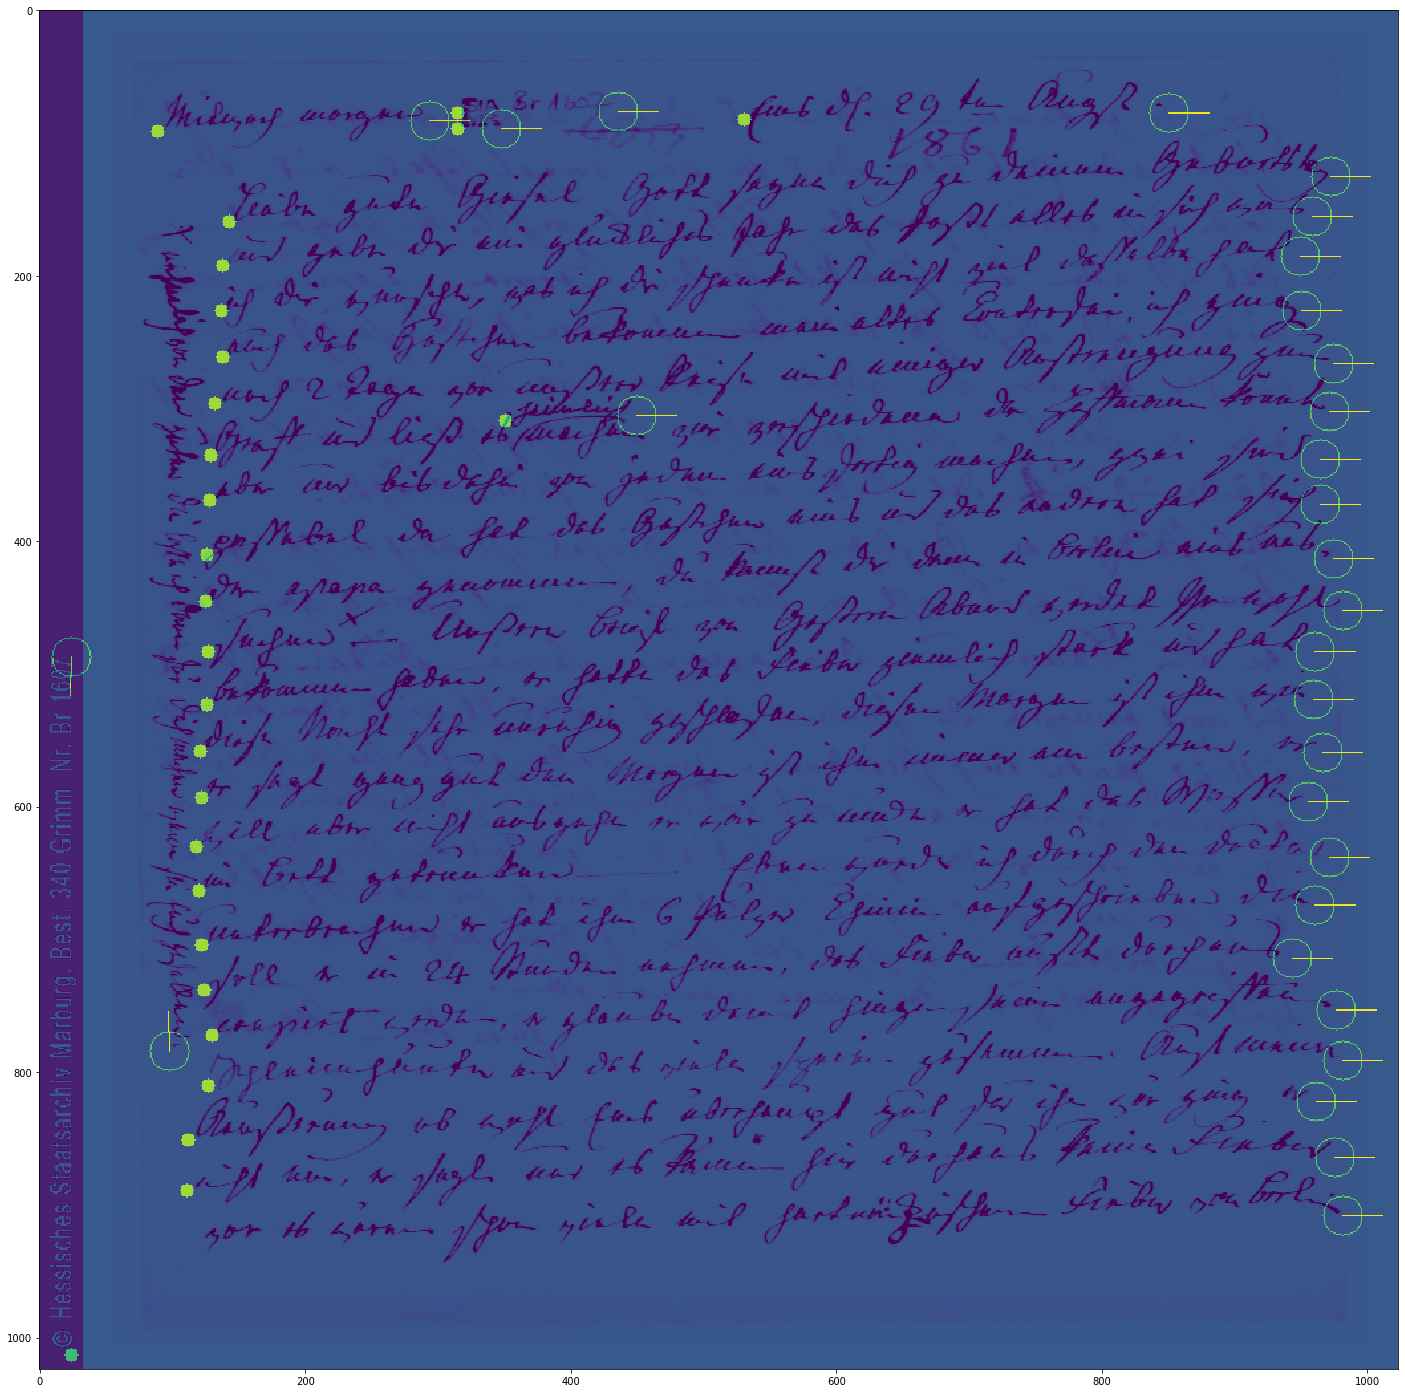

In [19]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.detach().numpy())

mask_img = np.zeros(image[0,0].shape, dtype=np.uint8)

for l in label_list:
    p = tuple(start_points[l].astype(int))
    cv2.circle(mask_img, p, radius=15, color=8, thickness=1, lineType=8, shift=0)
    angle = angles[l]
    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
    cv2.line(mask_img, p, p2, color=12)
    
    if l in end_points.keys():
        p = end_points[l]
        cv2.circle(mask_img, tuple(p.astype(int)), radius=5, color=10, thickness=-1, lineType=8, shift=0)
        
    
#for n, s in enumerate(new_sp):
#    p = tuple(s)
#    cv2.circle(mask_img, p, radius=5, color=13, thickness=-1, lineType=8, shift=0)
#    angle = new_angles[n]
#    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
#    cv2.line(mask_img, p, p2, color=12)
    
    
plt.figure(figsize=(25,25))
plt.imshow(mask_img+image[0,0,:,:].detach().numpy())

In [256]:
def segmentation_postprocessing2(array: np.array, sigma, threshold, open_kernel, erode_size):
    """
    Applies post processing steps to the segmentation output to better extract the start points.
    """
    #seg_blur = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
    #seg_thresh = (seg_blur > threshold) * 1.0
    #seg_open = cv2.morphologyEx(seg_thresh, cv2.MORPH_OPEN, (open_kernel, open_kernel))
    #out = cv2.erode(seg_open, (erode_size, erode_size), iterations=2)
    
    seg_blur = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
    seg_thresh = (seg_blur > threshold) * 1.0
    seg_open = cv2.morphologyEx(seg_thresh, cv2.MORPH_OPEN, (open_kernel, open_kernel))
    out = seg_open
    
    return out

In [306]:
#sm = nn.Softmax()

segmentation = np.transpose(seg_out.detach().numpy()[0], (1, 2, 0))

probs_start_points = segmentation[:, :, ld.class_idx['end_points']]
probs_end_points = segmentation[:, :, ld.class_idx['start_points']]
probs_baselines = segmentation[:, :, ld.class_idx['baselines']]
probs_border = segmentation[:, :, ld.class_idx['text']]
probs_bg = segmentation[:, :, ld.class_idx['bg']]

# Apply postprocessing:
# Postprozessing parameters
sigma = 0.3
threshold = 0.5
open_kernel = 3
erode_size = 3

# Extract baselines
bl = segmentation_postprocessing2(probs_baselines, sigma, threshold, open_kernel, erode_size)
_, bl_labels, bl_stats, bl_centroids = cv2.connectedComponentsWithStats(bl.astype(np.uint8))

# Extract baseline_borders
border = segmentation_postprocessing2(probs_border, sigma, threshold, open_kernel, erode_size)
_, border_labels, _, _ = cv2.connectedComponentsWithStats(border.astype(np.uint8))

# Extract start points
sp = segmentation_postprocessing2(probs_start_points, sigma, 0.3, open_kernel, erode_size)
_, _, _, start_points = cv2.connectedComponentsWithStats(sp.astype(np.uint8))

# Extract end points
ep = segmentation_postprocessing2(probs_end_points, sigma, threshold, open_kernel, erode_size)
_, _, _, end_points = cv2.connectedComponentsWithStats(ep.astype(np.uint8))

# Compute the angles and match start and end points
probs_sum = probs_start_points + probs_end_points + probs_baselines + 0.5*probs_border
ps = cv2.GaussianBlur(probs_sum, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
ps = (ps > 0.5) * 1.0
#ps = cv2.morphologyEx(ps, cv2.MORPH_GRADIENT, (3,3))
#ps = cv2.morphologyEx(ps, cv2.MORPH_CLOSE, (3, 3))
ps = cv2.morphologyEx(ps, cv2.MORPH_OPEN, (3, 3))
# TODO: remove start points that don't connect to a baseline
_, labels, stats, _ = cv2.connectedComponentsWithStats(ps.astype(np.uint8))

# stats is a matrix where for every label l the vector stats[l] is given by:
# [leftmost (x) coordinate, topmost (y) coordinate, width of bounding box, height of bouinding box, area]
# see https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python

# Assign labels to the start and end points
# [1:] because the background is also a component
sp_labels = {labels[(int(p[1]), int(p[0]))]: p for p in start_points[1:]}
ep_labels = {labels[(int(p[1]), int(p[0]))]: p for p in end_points[1:]}

label_list = sp_labels.keys()
angles = {l: np.arctan(stats[l][3] / stats[l][2]) for l in label_list}

bl_out_truth = contains_start_point(start_points, bl_stats)

In [266]:
start_points[1]

array([315.20408163,  77.83673469])

In [172]:
d2

<function src.utils.distances.d2(x1, y1, x2, y2)>

In [311]:
d_x = {3: 4, 5: 6, 3: 'test'}

In [312]:
d_x[3]

'test'

In [173]:
stats.shape

(35, 5)

In [177]:
cc_array = np.zeros((len(stats), 4, 2))

for n, cc in enumerate(stats):
    top_left = np.array([cc[0], cc[1]])
    top_right = np.array([cc[0]+cc[2], cc[1]])
    bottom_left = np.array([cc[0], cc[1]+cc[3]])
    bottom_right = np.array([cc[0]+cc[2], cc[1]+cc[3]])
    
    cc_array[n, 0, :] = top_left
    cc_array[n, 1, :] = top_right
    cc_array[n, 2, :] = bottom_left
    cc_array[n, 3, :] = bottom_right

In [189]:
np.array(2.5)**2

6.25

In [242]:
def d2_np(u, v):
    return np.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)

In [282]:
def get_cc_array(stats, area_thresh = 100):
    cc_array = np.zeros((len(stats), 4, 2))

    for n, cc in enumerate(stats):
        if cc[2]*cc[3] < area_thresh:
            top_left = -10000
            top_right = -10000
            bottom_left = -10000
            bottom_right = -10000
        else:
            top_left = np.array([cc[0], cc[1]])
            top_right = np.array([cc[0]+cc[2], cc[1]])
            bottom_left = np.array([cc[0], cc[1]+cc[3]])
            bottom_right = np.array([cc[0]+cc[2], cc[1]+cc[3]])

        cc_array[n, 0, :] = top_left
        cc_array[n, 1, :] = top_right
        cc_array[n, 2, :] = bottom_left
        cc_array[n, 3, :] = bottom_right
    
    return cc_array

def get_angles(cc_array, start_points):
    dist_array = -np.ones(cc_array.shape[0:2]) # The minus is for debug
    angles = np.zeros(len(start_points))
    
    for sp_idx, p in enumerate(start_points):
        for n in range(cc_array.shape[0]):
            for k in range(0,4):
                dist_array[n, k] = d2_np(p, cc_array[n, k, :])
                
        cc_idx, p_idx = np.unravel_index(np.argmin(dist_array, axis=None), dist_array.shape)
        
        if np.min(dist_array) < 0:
            print('something went wrong!')
            return 0
        
        bb_w = (cc_array[cc_idx, 1, 0] - cc_array[cc_idx, 0, 0])
        bb_h = (cc_array[cc_idx, 2, 1] - cc_array[cc_idx, 0, 1])
        
        if p_idx == 0: #top_left
            angle = np.arctan(-bb_h/bb_w)
        elif p_idx == 1: #top_right
            angle = np.arctan(-bb_w/bb_h) - np.pi/2.0
        elif p_idx == 2: #bottom_left         
            angle = np.arctan(bb_h/bb_w)
        elif p_idx == 3: #bottom_right       
            angle = np.arctan(bb_w/bb_h) + np.pi/2.0
        else:
            print('p_idx = {}'.format(p_idx))
            
        if np.pi*1.5 < angle < -np.pi*1.5:
            print('angle {} reset to 0 for point {}'.format(angle, sp_idx))
            angle = 0
        
        angles[sp_idx] = angle
        
    return angles

In [279]:
3 < 6 < 5

False

In [280]:
start_points[1]

array([315.20408163,  77.83673469])

In [281]:
cc_array = get_cc_array(stats)
angles = get_angles(cc_array, start_points[1:])

In [234]:
angles

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.12750956,
       -0.12750956, -0.12750956, -0.04874185, -0.04874185, -0.04874185,
       -0.04874185, -0.04386271, -0.04386271, -0.04386271, -0.04531779,
       -0.04531779, -0.04531779, -0.04691391, -0.04691391, -0.04691391,
       -0.04691391, -0.04242735, -0.04242735, -0.04242735, -0.04242735,
       -0.04242735, -0.04242735, -0.04242735, -0.04242735,  1.55575987])

In [213]:
angles.shape

(35, 4)

In [214]:
m_idx = np.unravel_index(np.argmin(angles, axis=None), angles.shape)

In [215]:
m_idx

(22, 3)

In [216]:
np.min(angles)

4.899944060480784

In [217]:
angles[22, 3]

4.899944060480784

In [210]:
np.amin(angles, axis=1)

array([  26.99212235, 1054.64445312,  975.83844033,  920.34256896,
        964.38029702, 1016.94196785,  989.93164493, 1103.5711836 ,
        858.07489836,  824.70253445,  856.10709451,  235.51425854,
        790.03035763,  757.22218948,  720.73360023,  681.71099376,
        772.20286863,  648.09967086,  607.29923207,  571.80280188,
        535.9489032 ,  497.10379536,    4.89994406,  460.83087614,
        426.83278558,  389.8858371 ,  356.9033615 ,  319.2181493 ,
        288.19658277,  257.98898   ,  224.42547106,  178.38151803,
        145.71491186,  122.11954538,  961.88933688])

In [170]:
stats

array([[     0,      0,   1024,   1024, 946836],
       [   529,     73,    327,     14,   1582],
       [   313,     74,    127,      7,    597],
       [    86,     81,    213,     14,   1025],
       [   313,     88,     39,      5,    138],
       [   470,     90,     39,      9,     96],
       [   423,    103,     29,      4,     92],
       [   663,    110,      7,      3,     16],
       [   140,    120,    836,     43,   4095],
       [   135,    151,    827,     45,   4124],
       [    94,    158,      1,      2,      2],
       [    90,    167,     14,    620,   2945],
       [   135,    184,    817,     47,   4097],
       [   134,    224,    820,     40,   4041],
       [   128,    262,    852,     38,   4170],
       [   125,    298,    851,     41,   4197],
       [   348,    303,    106,      9,    493],
       [   125,    336,    843,     37,   4213],
       [   123,    370,    845,     44,   4168],
       [   123,    406,    856,     44,   4219],
       [   126,    4

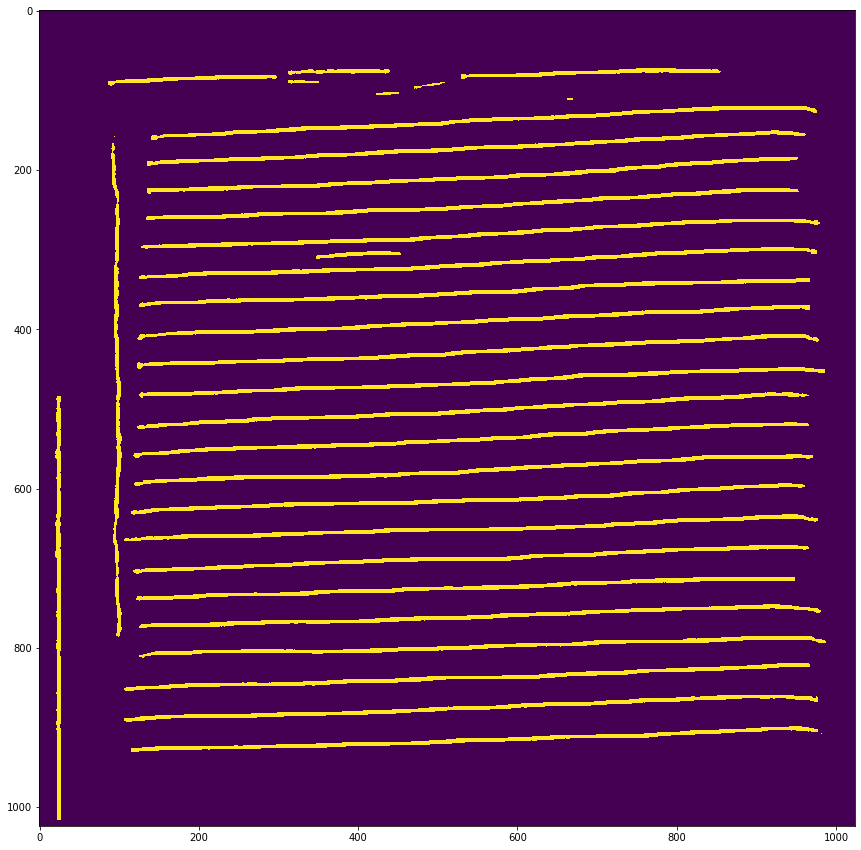

In [161]:
plt.figure(figsize=(15,15))
plt.imshow(ps)

In [272]:
start_points

array([[ 511.80083058,  511.52490966],
       [ 353.5       ,   77.        ],
       [ 315.52      ,   77.6       ],
       [ 531.66666667,   82.25      ],
       [  89.40540541,   91.18918919],
       [ 315.        ,   89.66666667],
       [ 143.16216216,  159.7027027 ],
       [ 138.29268293,  192.46341463],
       [ 137.60526316,  226.71052632],
       [ 138.17948718,  261.07692308],
       [ 132.7       ,  296.6       ],
       [ 351.43478261,  309.39130435],
       [ 129.03571429,  335.32142857],
       [ 128.19047619,  369.85714286],
       [ 126.71428571,  410.28571429],
       [ 125.45454545,  445.90909091],
       [ 127.9       ,  483.05      ],
       [ 126.97435897,  523.07692308],
       [ 121.91666667,  558.33333333],
       [ 122.66666667,  593.88888889],
       [ 118.67567568,  630.54054054],
       [ 109.5       ,  664.        ],
       [ 120.60869565,  663.56521739],
       [ 122.20689655,  704.31034483],
       [ 124.60869565,  738.34782609],
       [ 130.        ,  7

In [270]:
stats[3]

array([  86,   77,  213,   18, 1700], dtype=int32)

In [269]:
sp_labels

{1: array([315.52,  77.6 ]),
 2: array([531.66666667,  82.25      ]),
 3: array([89.40540541, 91.18918919]),
 4: array([315.        ,  89.66666667]),
 8: array([143.16216216, 159.7027027 ]),
 9: array([138.29268293, 192.46341463]),
 11: array([137.60526316, 226.71052632]),
 12: array([138.17948718, 261.07692308]),
 14: array([132.7, 296.6]),
 16: array([351.43478261, 309.39130435]),
 15: array([129.03571429, 335.32142857]),
 17: array([128.19047619, 369.85714286]),
 18: array([126.71428571, 410.28571429]),
 19: array([125.45454545, 445.90909091]),
 20: array([127.9 , 483.05]),
 21: array([126.97435897, 523.07692308]),
 23: array([121.91666667, 558.33333333]),
 24: array([122.66666667, 593.88888889]),
 25: array([118.67567568, 630.54054054]),
 10: array([120.60869565, 663.56521739]),
 26: array([122.20689655, 704.31034483]),
 27: array([124.60869565, 738.34782609]),
 28: array([130.        , 772.89655172]),
 29: array([127.        , 810.16666667]),
 30: array([112.075, 851.95 ]),
 31: a

In [11]:
def is_in_box(point, left, top, width, height):
    x = point[0]
    y = point[1]

    if left < x < left + width:
        if top < y < top + height:
            return True

    return False


def contains_start_point(points, bl_stats, buff_low=5, buff_high=10):
    comp_contains_sp = []
    for n, bl_s in enumerate(bl_stats):

        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3]

        if width > height:
            left -= buff_low
            width += buff_high
        else:
            top -= buff_low
            height += buff_high

        contains_sp_switch = False
        for p in points:
            if is_in_box(p, left, top, width, height):
                comp_contains_sp.append(True)
                contains_sp_switch = True
                break

        if not contains_sp_switch:
            comp_contains_sp.append(False)

    return comp_contains_sp


In [265]:
bl_out_truth

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 

In [260]:
stats

array([[     0,      0,   1024,   1024, 878138],
       [   313,     71,    127,     10,    994],
       [   528,     70,    328,     17,   2656],
       [    86,     77,    213,     18,   1700],
       [   313,     84,     39,      9,    250],
       [   415,     87,     98,     21,    752],
       [   662,    107,     22,      7,    102],
       [   645,    108,     10,      4,     27],
       [   140,    117,    836,     46,   6778],
       [   135,    148,    827,     48,   6694],
       [    90,    158,    887,    629,  13243],
       [   135,    181,    817,     50,   6633],
       [   134,    220,    820,     44,   6705],
       [   958,    245,      3,      2,      6],
       [   128,    257,    852,     43,   6898],
       [   124,    295,    852,     44,   6940],
       [   348,    300,    106,     12,    801],
       [   124,    333,    845,     40,   6890],
       [   123,    367,    846,     47,   6859],
       [   123,    404,    856,     46,   6980],
       [   126,    4

In [259]:
label_list

dict_keys([1, 2, 3, 4, 8, 9, 11, 12, 14, 16, 15, 17, 18, 19, 20, 21, 23, 24, 25, 10, 26, 27, 28, 29, 30, 31, 32, 22])

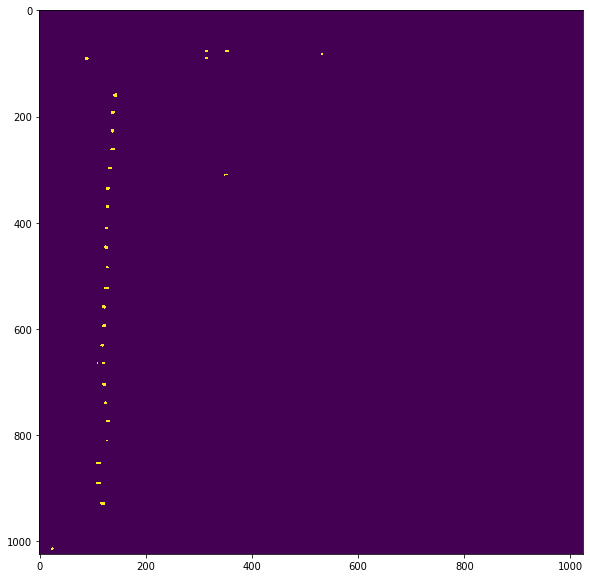

In [256]:
plt.figure(figsize=(10,10))
plt.imshow(sp)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


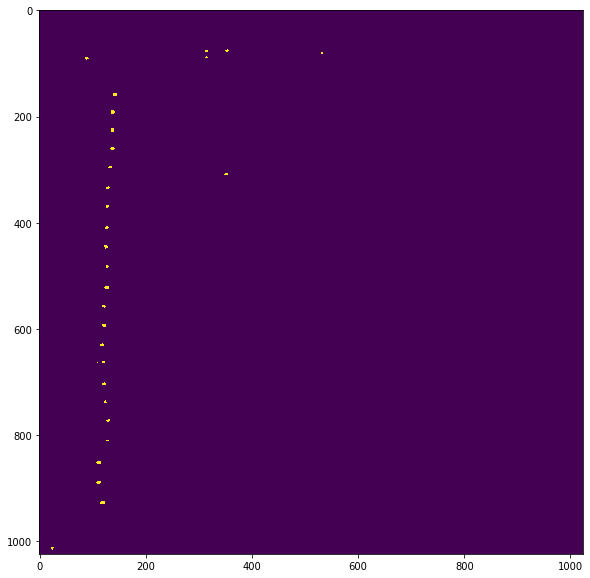

In [82]:
c = 'start_points'

plt.figure(figsize=(10,10))
plt.imshow(sm(seg_out)[0].permute(1,2,0)[:,:,ld.classes.index(c)]>0.5)

In [230]:
bl, border, sp, ep = ld.extract_start_points_and_angles(seg_out.detach().numpy())

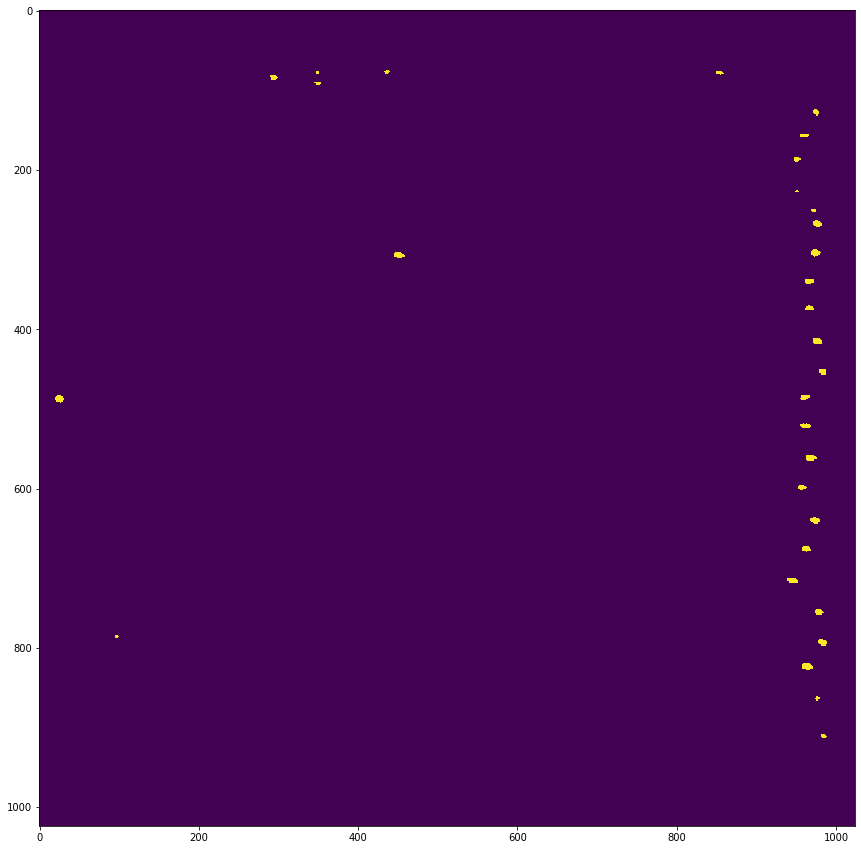

In [92]:
plt.figure(figsize=(15,15))
plt.imshow(ep)

In [273]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.detach().numpy())

In [232]:
start_points

array([[ 511.80083058,  511.52490966],
       [ 353.5       ,   77.        ],
       [ 315.52      ,   77.6       ],
       [ 531.66666667,   82.25      ],
       [  89.40540541,   91.18918919],
       [ 315.        ,   89.66666667],
       [ 143.16216216,  159.7027027 ],
       [ 138.29268293,  192.46341463],
       [ 137.60526316,  226.71052632],
       [ 138.17948718,  261.07692308],
       [ 132.7       ,  296.6       ],
       [ 351.43478261,  309.39130435],
       [ 129.03571429,  335.32142857],
       [ 128.19047619,  369.85714286],
       [ 126.71428571,  410.28571429],
       [ 125.45454545,  445.90909091],
       [ 127.9       ,  483.05      ],
       [ 126.97435897,  523.07692308],
       [ 121.91666667,  558.33333333],
       [ 122.66666667,  593.88888889],
       [ 118.67567568,  630.54054054],
       [ 109.5       ,  664.        ],
       [ 120.60869565,  663.56521739],
       [ 122.20689655,  704.31034483],
       [ 124.60869565,  738.34782609],
       [ 130.        ,  7

In [233]:
angles

{1: 0.3430239404207034,
 2: 0.5880026035475675,
 0: 0.7853981633974483,
 3: 0.5404195002705842,
 4: 0.7086262721276703,
 5: 0.6947382761967033,
 6: 0.5585993153435624,
 7: 0.8760580505981934,
 8: 0.4636476090008061,
 9: 0.4636476090008061,
 11: 0.5585993153435624,
 12: 0.6747409422235527,
 13: 1.0516502125483738,
 14: 0.8960553845713439,
 17: 0.6435011087932844,
 18: 0.7853981633974483,
 19: 0.6435011087932844,
 20: 0.5191461142465229,
 21: 0.4636476090008061,
 22: 0.9272952180016122,
 23: 0.7853981633974483,
 24: 0.5880026035475675,
 25: 0.5404195002705842,
 27: 0.5880026035475675,
 28: 0.4636476090008061,
 29: 0.4636476090008061,
 30: 0.6947382761967033}

In [234]:
end_points

array([[511.36361399, 511.50694884],
       [436.85714286,  75.71428571],
       [294.85714286,  83.07142857],
       [349.        ,  90.5       ],
       [973.61538462, 126.23076923],
       [958.        , 155.        ],
       [975.58064516, 266.70967742],
       [972.92      , 302.96      ],
       [450.        , 305.36363636],
       [965.        , 338.28571429],
       [965.16666667, 372.66666667],
       [975.125     , 413.33333333],
       [982.42307692, 452.34615385],
       [ 23.84615385, 486.96153846],
       [960.87878788, 519.54545455],
       [967.35294118, 559.94117647],
       [956.5       , 596.8       ],
       [972.62068966, 638.55172414],
       [962.        , 674.36363636],
       [945.        , 713.66666667],
       [977.39130435, 753.82608696],
       [982.37931034, 791.51724138],
       [962.52173913, 821.91304348]])

In [77]:
sample = ds[0]
print('filename: {}'.format(sample['filename']))

filename: ..\data\cBAD-ICDAR2019\test\cPAS-0003.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


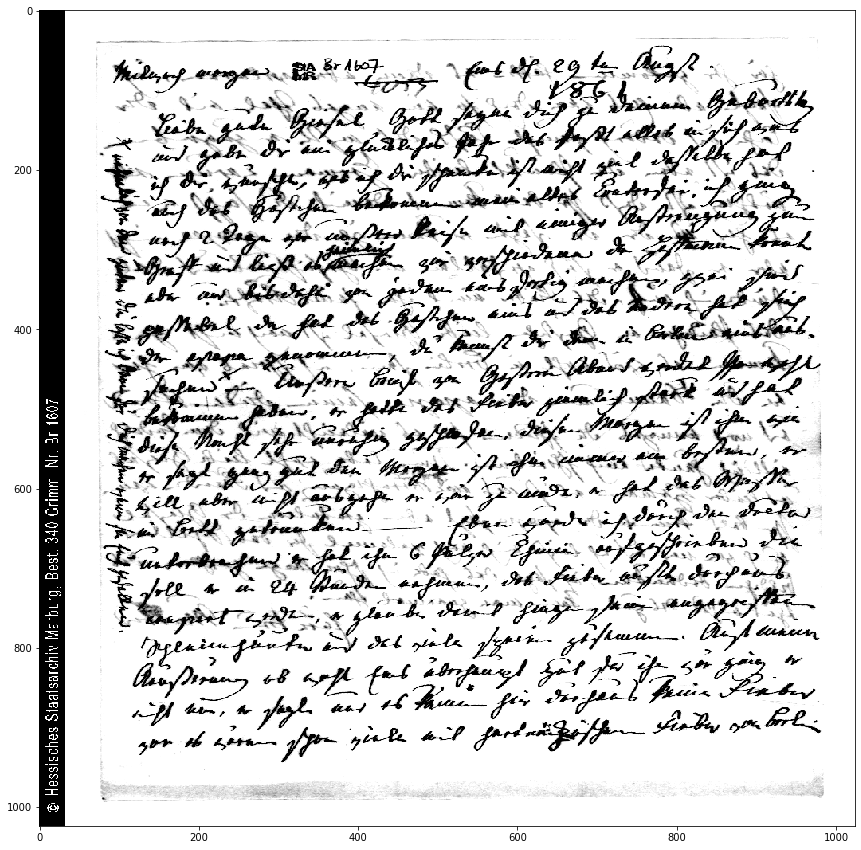

In [78]:
plt.figure(figsize=(15,15))
plt.imshow(sample['image'].permute(1,2,0).detach().numpy())

In [80]:
image = sample['image'].unsqueeze(0)
#seg_out = ld.line_finder_seg(image)[0][0]

In [81]:
plt.figure(figsize=(15,15))
plt.imshow(seg_out[4,:,:].detach().numpy()>0.9)

IndexError: index 4 is out of bounds for dimension 0 with size 1

<Figure size 1080x1080 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


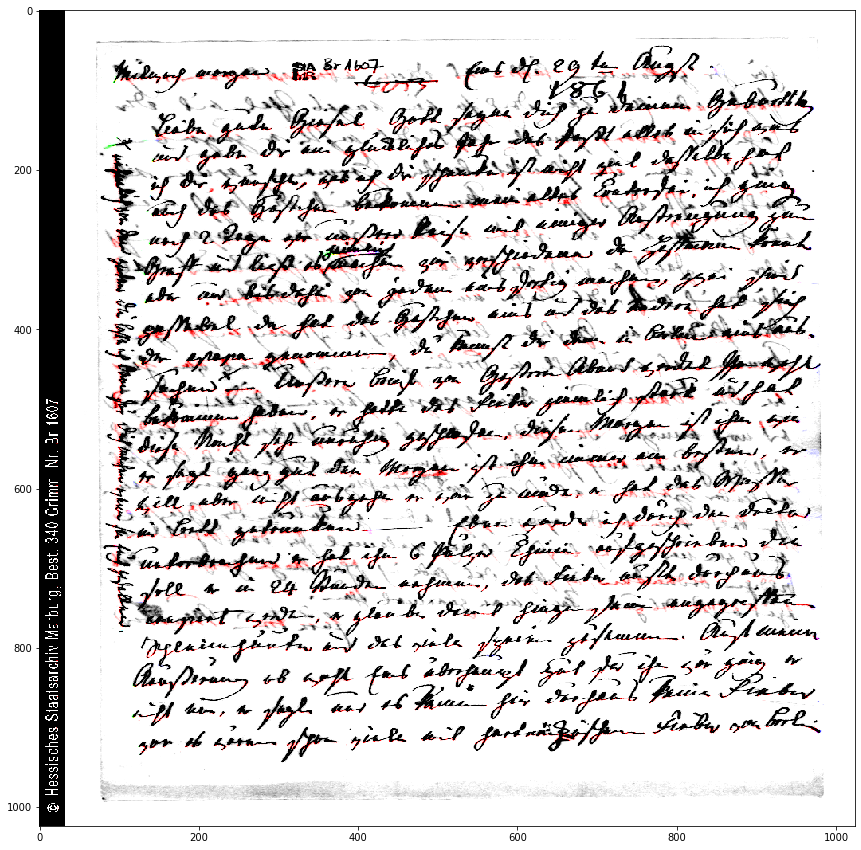

In [71]:
plt.figure(figsize=(15,15))
plt.imshow(image[0].permute(1,2,0).detach().numpy() + seg_out[[0, 3, 4],:,:].permute(1,2,0).detach().numpy())

In [177]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.unsqueeze(0).detach().numpy())

ValueError: axes don't match array

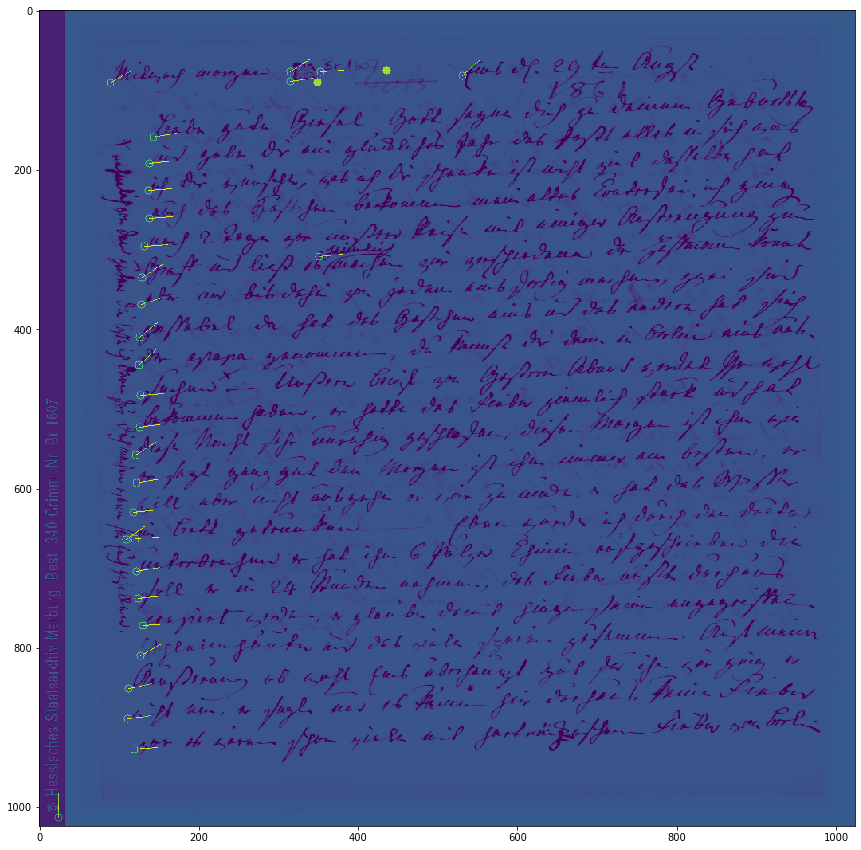

In [274]:
mask_img = np.zeros(image[0,0].shape, dtype=np.uint8)

for l in label_list:
    p = tuple(start_points[l].astype(int))
    cv2.circle(mask_img, p, radius=5, color=8, thickness=1, lineType=8, shift=0)
    angle = angles[l]
    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
    cv2.line(mask_img, p, p2, color=12)
    
    if l in end_points.keys():
        p = end_points[l]
        cv2.circle(mask_img, tuple(p.astype(int)), radius=5, color=10, thickness=-1, lineType=8, shift=0)
        
    
#for n, s in enumerate(new_sp):
#    p = tuple(s)
#    cv2.circle(mask_img, p, radius=5, color=13, thickness=-1, lineType=8, shift=0)
#    angle = new_angles[n]
#    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
#    cv2.line(mask_img, p, p2, color=12)
    
    
plt.figure(figsize=(15,15))
plt.imshow(mask_img+image[0,0,:,:].detach().numpy())

In [147]:
seg_out.shape

torch.Size([7, 1024, 1024])

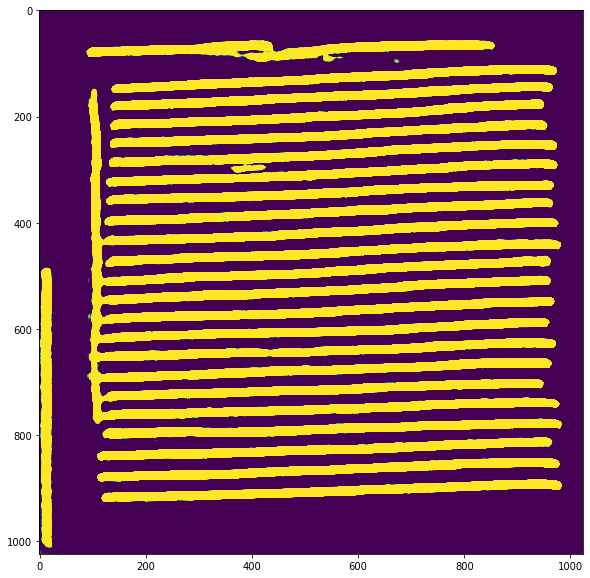

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(seg_out[5,:,:].detach().numpy())

In [22]:
# Postprozessing parameters
sigma = 0.3
threshold = 0.99
morph_close_size = 3
erode_size = 3

In [49]:
def segmentation_postprocessing(array: np.array, sigma, threshold, morph_close_size, erode_size):
    out = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
    out = (out > threshold) * 1.0
    out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, (morph_close_size, morph_close_size))
    out = cv2.erode(out, (erode_size, erode_size), iterations=2)

    return out

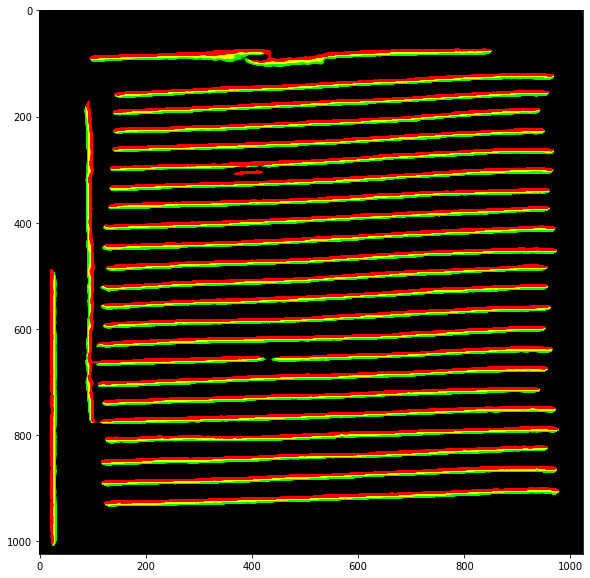

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(seg_out_np[:,:,0:3])

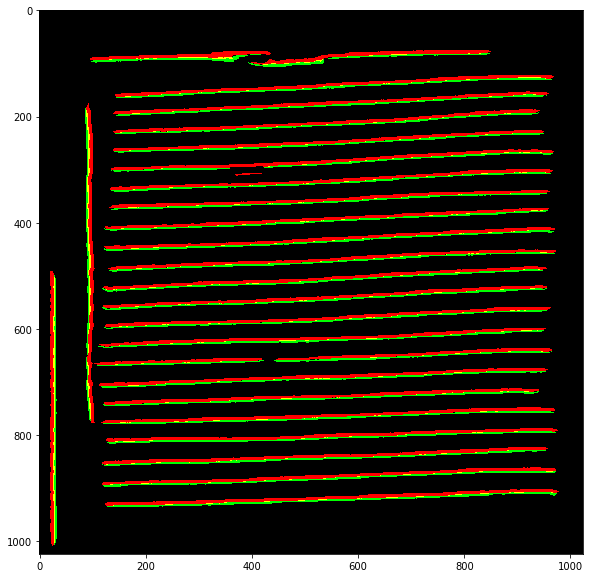

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(segmentation_postprocessing(seg_out_np, sigma, threshold, morph_close_size*3, erode_size)[:,:,0:3])

In [24]:
def d2(x1, y1, x2, y2):
    """
    Computes the euclidian distance between the two points (x1, y1) and (x2, y2).
    """
    return torch.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))

def get_smallest_distance(point, point_list):
    d_min = 1e10

    for p in point_list:
        d = d2(p[0], p[1], point[0], point[1])
        if d > 0:
            d_min = min(d_min, d)

    return d_min

In [25]:
seg_out_np = seg_out.permute(1,2,0).detach().numpy()

In [26]:
out = segmentation_postprocessing(seg_out_np, sigma, threshold, morph_close_size, erode_size)

In [57]:
bl_seg = out[:,:,0]
border_seg = out[:,:,1]
text_seg = out[:,:,5]
start_seg = out[:,:,3]

bl_seg = out[:,:,0]+out[:,:,1]

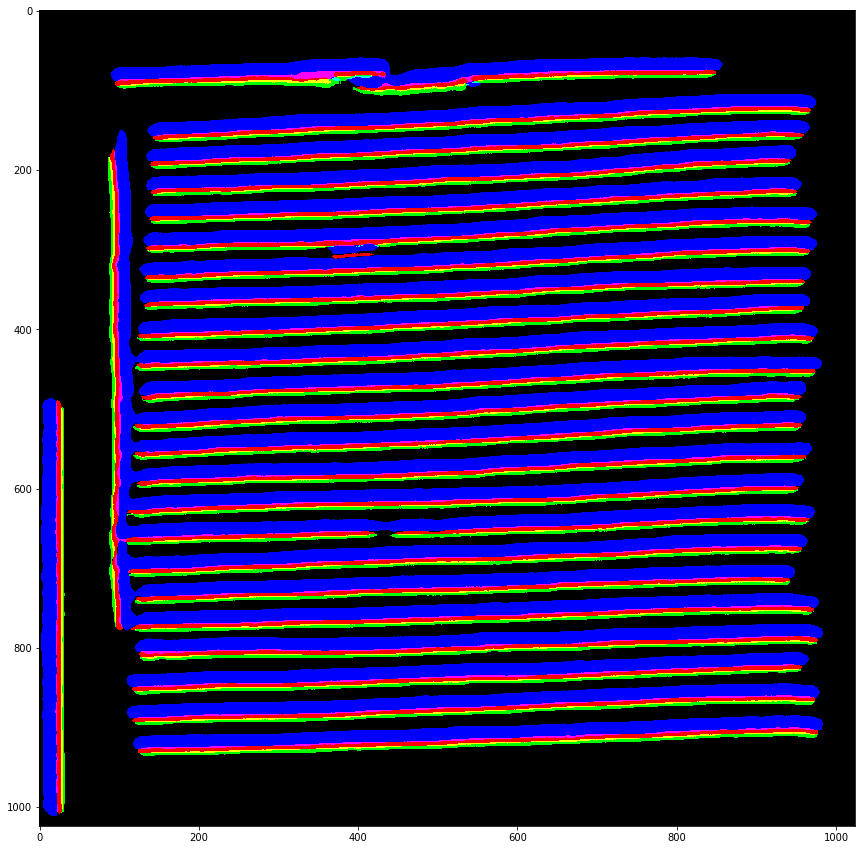

In [28]:
plt.figure(figsize=(15,15))
plt.imshow(out[:,:,[0,1,5]])

In [58]:
bl_num_labels, bl_labels, bl_stats, bl_centroids = cv2.connectedComponentsWithStats(bl_seg.astype(np.uint8))
border_num_labels, border_labels, border_stats, border_centroids = cv2.connectedComponentsWithStats(border_seg.astype(np.uint8))
text_num_labels, text_labels, text_stats, text_centroids = cv2.connectedComponentsWithStats(text_seg.astype(np.uint8))
start_num_labels, start_labels, start_stats, start_centroids = cv2.connectedComponentsWithStats(text_seg.astype(np.uint8))

bl_seg_num_labels, bl_seg_labels, bl_seg_stats, bl_seg_centroids = cv2.connectedComponentsWithStats(bl_seg.astype(np.uint8))

In [144]:
bl_stats[15]

array([ 121,  407,  851,   46, 8425], dtype=int32)

In [163]:
bl_stats

array([[     0,      0,   1024,   1024, 846863],
       [   394,     74,    456,     34,   4919],
       [    96,     76,    340,     23,   4099],
       [   143,    121,    827,     45,   8208],
       [   139,    152,    821,     47,   7856],
       [    86,    175,    338,    603,   9523],
       [   139,    186,    805,     48,   7775],
       [   138,    224,    813,     45,   7908],
       [   134,    261,    836,     44,   7991],
       [   398,    296,      1,      1,      1],
       [   400,    296,      1,      1,      1],
       [   133,    298,    835,     44,   8076],
       [   368,    305,     52,      7,    199],
       [   131,    338,    830,     38,   8028],
       [   123,    371,    837,     45,   8176],
       [   121,    407,    851,     46,   8425],
       [   128,    449,    847,     44,   8237],
       [   118,    481,    839,     49,   8213],
       [    20,    490,     13,    519,   5564],
       [   118,    517,    840,     48,   8251],
       [   123,    5

In [73]:
def is_in_box(point, left, top, width, height):
    x = point[0]
    y = point[1]
    
    if left < x < left+width:
        if top < y < top+height:
            return True
        
    return False

In [129]:
def contains_start_point(points, bl_stats):
    comp_contains_sp = []
    for n, bl_s in enumerate(bl_stats):
        
        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3]
        
        if width > height:
            left -= 5
            width += 10
        else:
            top -= 5
            height += 10            
        
        contains_sp_switch = False
        for p in points:
            if is_in_box(p, left, top, width, height):
                comp_contains_sp.append(True)
                contains_sp_switch = True
                break
                
        if not contains_sp_switch:  
            comp_contains_sp.append(False)
        
    return comp_contains_sp

In [130]:
bl_out_truth = contains_start_point(start_centroids, bl_stats)

In [172]:
bl_centroids[4]

array([549.69348269, 175.44424644])

In [207]:
import math

new_sp = []
new_angles = []

for n, bl_s in enumerate(bl_stats):
    if not bl_out_truth[n]:
        
        left = bl_s[0]
        top = bl_s[1]
        width = bl_s[2]
        height = bl_s[3] 
        area = bl_s[4]
        
        if area < 3000:
            continue
            
        if width > height:
            for y in range(top, top+height):
                if bl_labels[y, left+1] == n:
                    new_sp.append([left, y])  
                    new_angles.append(0.0)
                    break
        else:
            y_direction = 0
            
            for x in range(left, left+width):
                if bl_labels[top+10, x] == n:
                    y_direction = -1
                    break
                elif border_labels[top+10, x] != 0:
                    y_direction = 1
                    break
                    
            if y_direction < 0: #from bottom up
                for x in range(left, left+width):
                    if bl_labels[top+height-1, x] == n:
                        new_sp.append([x, top+height-1])   
                        new_angles.append(math.pi/2)
                        break
            elif y_direction > 0: #from up to down
                for x in range(left, left+width):
                    if bl_labels[top+1, x] == n:
                        new_sp.append([x, top+1])   
                        new_angles.append(-math.pi/2)
                        break
        

In [208]:
new_angles

[0.0, 0.0, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [197]:
new_sp

[[96, 89],
 [121, 447],
 [20, 447],
 [118, 558],
 [111, 629],
 [441, 659],
 [112, 703],
 [121, 738],
 [115, 775]]

In [188]:
new_sp

[[96, 89],
 [121, 447],
 [118, 558],
 [111, 629],
 [441, 659],
 [112, 703],
 [121, 738],
 [115, 775]]

In [131]:
len(bl_stats)

30

In [132]:
bl_out_truth

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [133]:
sum(bl_out_truth*1)

18

In [134]:
len(start_centroids)

18

In [135]:
start_centroids

array([[510.69489553, 516.12094078],
       [469.81452577,  74.51311256],
       [555.7491063 , 129.47209455],
       [549.34436697, 163.52807339],
       [508.49001585, 589.34050297],
       [544.58867529, 199.53975615],
       [544.75304787, 235.55902468],
       [550.54199637, 271.57255898],
       [551.68807608, 308.15991222],
       [392.94107143, 299.0125    ],
       [547.42449128, 344.38989826],
       [544.54681485, 381.34284884],
       [553.54607801, 456.9885698 ],
       [ 13.35505251, 746.31467319],
       [546.40543585, 789.21560344],
       [535.64509246, 828.22937411],
       [544.38533399, 866.29479525],
       [552.09993002, 906.43463961]])

In [30]:
def d2(x1, y1, x2, y2):
    """
    Computes the euclidian distance between the two points (x1, y1) and (x2, y2).
    """
    return np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))

def get_closest_point(point, point_list):
    d_min = 1e10
    n_closest = 0

    for n in range(len(point_list)):
        p = point_list[n]
        d = d2(p[0], p[1], point[0], point[1])
        if d > 0 and d < d_min:
            d_min = d
            n_closest = n

    return n_closest, d_min

In [31]:
area_threshold = 1000

for bl in range(bl_num_labels):
    stats = bl_stats[bl]
    
    if stats[4] < area_threshold:
        continue
    else:
        centroid = bl_centroids[bl]
        border_label, _ = get_closest_point(centroid, border_centroids)
        print('bl: {}; border: {}'.format(bl, border_label))
        print(centroid-border_centroids[border_label])

bl: 0; border: 0
[ 0.06968083 -0.18273082]
bl: 1; border: 1
[-79.23913529   2.70130415]
bl: 2; border: 2
[ 2.76961375 -3.85654589]
bl: 3; border: 4
[-2.11099385 -2.68545858]
bl: 4; border: 5
[-2.40918672 -2.60474154]
bl: 5; border: 6
[56.25544272 72.28175427]
bl: 6; border: 7
[ 0.81862388 -2.76794465]
bl: 7; border: 8
[-1.88482829 -2.64923227]
bl: 8; border: 8
[ 9.24923043 32.88205804]
bl: 11; border: 15
[-0.92422707 -2.6843494 ]
bl: 13; border: 16
[ 0.23895385 -2.7451298 ]
bl: 14; border: 17
[ 2.6222025  -2.83516415]
bl: 15; border: 18
[ 3.16124831 -2.92884356]
bl: 16; border: 19
[ 0.33968115 -2.75057454]
bl: 17; border: 20
[ 1.74508597 -2.8102713 ]
bl: 18; border: 21
[-3.20773528 -6.74970459]
bl: 19; border: 22
[ 1.18816009 -2.82087111]
bl: 20; border: 23
[-0.26009207 -2.77240699]
bl: 21; border: 24
[-3.4361386 -2.6639845]
bl: 22; border: 25
[ 9.28825603 -2.96128942]
bl: 23; border: 27
[ 0.16980543 -2.78065195]
bl: 24; border: 28
[ 0.41496823 -2.78125821]
bl: 25; border: 29
[-1.42904

In [129]:
bl_stats[0]

array([     0,      0,   1024,   1024, 970679], dtype=int32)

In [112]:
bl_num_labels

16

In [113]:
border_num_labels

16

In [115]:
text_num_labels

17

In [120]:
bl_c_dict = {l: bl_centroids[l] for l in range(bl_num_labels)}

In [ ]:
border_to_bl_dict = {l: bl_seg}

In [116]:
bl_centroids

array([[512.79488121, 514.2208111 ],
       [525.84036048, 117.10894754],
       [497.23974189, 192.84877565],
       [251.74081091, 270.2171277 ],
       [505.885233  , 333.37956549],
       [525.83215866, 412.67218489],
       [503.92494824, 489.2600069 ],
       [567.03622047, 567.37007874],
       [511.32514907, 642.06681866],
       [324.08357257, 721.04593301],
       [757.92959087, 774.7659372 ],
       [346.08239376, 786.03873952],
       [735.45780051, 831.77621483],
       [681.        , 833.5       ],
       [391.04077762, 847.49359886],
       [734.7365224 , 896.25132878]])

In [109]:
stats

array([[     0,      0,   1024,   1024, 996603],
       [    97,    101,    849,     31,   6214],
       [    91,    179,    811,     32,   6044],
       [    83,    260,    337,     21,   2639],
       [    87,    315,    846,     36,   6352],
       [   107,    398,    835,     28,   6101],
       [   111,    474,    784,     29,   5796],
       [   477,    563,    183,     10,   1270],
       [   105,    630,    818,     25,   5702],
       [   113,    715,    421,     14,   3135],
       [   683,    769,    148,     12,   1051],
       [   123,    777,    439,     18,   3459],
       [   683,    827,    108,     10,    782],
       [   681,    833,      1,      2,      2],
       [   249,    843,    273,     10,   2109],
       [   649,    891,    168,     12,   1317]], dtype=int32)

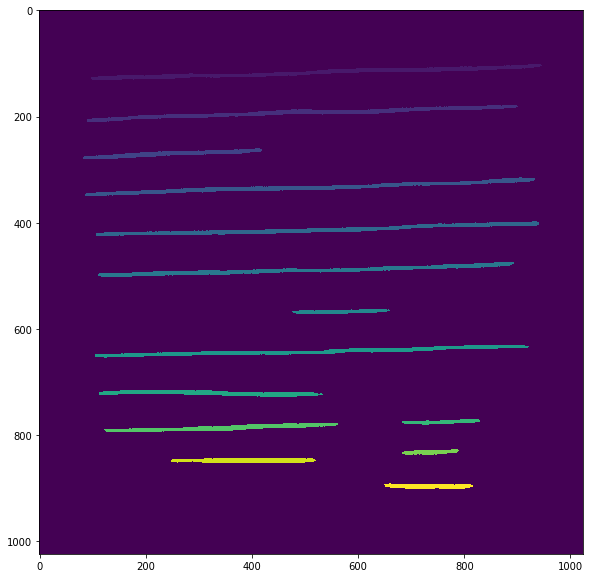

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(labels)